In [1]:
#@title Imports

import collections
import copy
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import loggamma
from scipy.stats import beta
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

import tensorflow.compat.v2 as tf
# import tensorflow_probability as tfp
tf.enable_v2_behavior()
from tensorflow import keras

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.7.12
matplotlib 3.2.2


In [2]:
#@title Bandit simulator and environments

class GaussBandit(object):
  """Gaussian bandit."""

  def __init__(self, mu, sigma=0.5):
    self.mu = np.copy(mu)
    self.K = self.mu.size
    self.sigma = sigma

    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    self.rt = self.mu + self.sigma * np.random.randn(self.K)

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    return "Gaussian bandit with arms (%s)" % \
      ", ".join("%.3f" % s for s in self.mu)


class LinBandit(object):
  """Linear bandit."""

  def __init__(self, X, theta, noise="normal", sigma=0.5):
    self.X = np.copy(X)
    self.K = self.X.shape[0]
    self.d = self.X.shape[1]
    self.theta = np.copy(theta)
    self.noise = noise
    if self.noise == "normal":
      self.sigma = sigma

    self.mu = self.X.dot(self.theta)
    self.best_arm = np.argmax(self.mu)

    self.randomize()

  def randomize(self):
    # generate random rewards
    if self.noise == "normal":
      self.rt = self.mu + self.sigma * np.random.randn(self.K)
    elif self.noise == "bernoulli":
      self.rt = (np.random.rand(self.K) < self.mu).astype(float)
    elif self.noise == "beta":
      self.rt = np.random.beta(4 * self.mu, 4 * (1 - self.mu))

  def reward(self, arm):
    # instantaneous reward of the arm
    return self.rt[arm]

  def regret(self, arm):
    # instantaneous regret of the arm
    return self.rt[self.best_arm] - self.rt[arm]

  def pregret(self, arm):
    # expected regret of the arm
    return self.mu[self.best_arm] - self.mu[arm]

  def print(self):
    if self.noise == "normal":
      return "Linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)
    elif self.noise == "bernoulli":
      return "Bernoulli linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)
    elif self.noise == "beta":
      return "Beta linear bandit: %d dimensions, %d arms" % \
        (self.d, self.K)


In [3]:
#@title Baseline algorithms that handle each task independently

class GaussTS(object):
  def __init__(self, K, params):
    self.K = K
    self.sigma = 0.5

    self.mu0 = np.zeros(self.K)
    self.sigma0 = 0.5 * np.ones(self.K)

    for attr, val in params.items():
      setattr(self, attr, val)

    self.pulls = np.zeros(self.K)  # number of pulls
    self.reward = np.zeros(self.K)  # cumulative reward

  def update(self, t, arm, r):
    self.pulls[arm] += 1
    self.reward[arm] += r

  def get_arm(self, t):
    if t < self.K:
      # each arm is initially pulled once
      self.mu = np.zeros(self.K)
      self.mu[t] = 1
    else:
      # posterior distribution
      sigma2 = np.square(self.sigma)
      sigma02 = np.square(self.sigma0)
      post_var = 1.0 / (1.0 / sigma02 + self.pulls / sigma2)
      post_mean = post_var * (self.mu0 / sigma02 + self.reward / sigma2)

      # posterior sampling
      self.mu = post_mean + np.sqrt(post_var) * np.random.randn(self.K)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "Gaussian TS"


class LinBanditAlg(object):
  def __init__(self, K, d, params):
    self.K = K
    self.d = d
    self.theta0 = np.zeros(self.d)
    self.sigma0 = 1.0
    self.sigma = 0.5
    self.crs = 1.0 # confidence region scaling

    for attr, val in params.items():
      setattr(self, attr, val)

    if not hasattr(self, "Sigma0"):
      self.Sigma0 = np.square(self.sigma0) * np.eye(self.d)

    # sufficient statistics
    self.Gram = np.linalg.inv(self.Sigma0)
    self.B = self.Gram.dot(self.theta0)

  def update(self, t, x, arm, r):
    x_a = x[arm]
    self.Gram += np.outer(x_a, x_a) / np.square(self.sigma)
    self.B += x_a * r / np.square(self.sigma)


class LinTS(LinBanditAlg):
  def get_arm(self, t, x):
    Gram_inv = np.linalg.inv(self.Gram)
    thetabar = Gram_inv.dot(self.B)

    # posterior sampling
    thetatilde = np.random.multivariate_normal(thetabar,
      np.square(self.crs) * Gram_inv, tol=1e-6)
    self.mu = x.dot(thetatilde)

    arm = np.argmax(self.mu)
    return arm

  @staticmethod
  def print():
    return "LinTS"

In [4]:
class IndLinTS(object):
  def __init__(self, num_tasks, K, d, params):
      self.num_tasks = num_tasks
      self.K = K
      self.d = d

      # set up independent bandit algorithms
      self.algs = []
      for _ in range(num_tasks):
        self.algs.append(LinTS(K, d, copy.deepcopy(params)))

  def update(self, t, tasks, xs, arms, rs):
    for s, x, arm, r in zip(tasks, xs, arms, rs):
      self.algs[s].update(t, x, arm, r)

  def get_arm(self, t, tasks, xs):
    return [self.algs[s].get_arm(t, x) for s, x in zip(tasks, xs)]


class HierLinTS(object):
  def __init__(self, num_tasks, K, d, params):
      self.num_tasks = num_tasks
      self.K = K
      self.d = d
      self.mu_q = np.zeros(self.d)
      self.Sigma_q = np.eye(self.d)
      self.sigma0 = 1.0
      self.sigma = 0.5
      self.crs = 1.0  # confidence region scaling

      for attr, val in params.items():
        setattr(self, attr, val)

      if not hasattr(self, "Sigma0"):
        self.Sigma0 = np.square(self.sigma0) * np.eye(self.d)

      # hyper-posterior
      self.mu_tildes = np.tile(self.mu_q, (self.num_tasks, 1))
      self.Sigma_tildes = np.tile(self.Sigma_q, (self.num_tasks, 1, 1))
  
      # sufficient statistics
      self.Grams= (np.zeros((self.num_tasks, self.d, self.d)) +
                   1e-6 * np.eye(self.d)[np.newaxis, ...])
      self.Bs = np.zeros((self.num_tasks, self.d))
      self.counts = np.zeros(self.num_tasks)


  def update(self, t, tasks, xs, arms, rs):
    for s, x, arm, r in zip(tasks, xs, arms, rs):
      x_a = x[arm]
      self.Grams[s] += np.outer(x[arm], x[arm]) / np.square(self.sigma)
      self.Bs[s] += x[arm] * r / np.square(self.sigma)
      self.counts[s] += 1

    # hyper-posterior update
    mu_h = np.linalg.solve(self.Sigma_q, self.mu_q)
    Lambda_h = np.linalg.inv(self.Sigma_q)

    # compute hyper-posterior parameters
    for s in range(self.num_tasks):
      if self.counts[s] >= self.d:
        Gram = self.Grams[s]
        B = self.Bs[s]
        M = np.linalg.pinv(np.linalg.inv(self.Sigma0) + Gram)
        Lambda_h += Gram - Gram.dot(M).dot(Gram)
        mu_h += B - Gram.dot(M).dot(B)

    for s in range(self.num_tasks):
      mu_h_s = np.copy(mu_h)
      Lambda_h_s = np.copy(Lambda_h)
      if self.counts[s] >= self.d:
        Gram = self.Grams[s]
        B = self.Bs[s]
        M = np.linalg.pinv(np.linalg.inv(self.Sigma0) + Gram)
        # subtract observations from task to keep independence
        mu_h_s -= (B - Gram.dot(M).dot(B))
        Lambda_h_s -= (Gram - Gram.dot(M).dot(Gram))

      self.mu_tildes[s] = np.linalg.solve(Lambda_h_s, mu_h_s)
      self.Sigma_tildes[s] = np.linalg.pinv(Lambda_h_s)

  def get_arm(self, t, tasks, xs):
    arms = []
    for s, x in zip(tasks, xs):
      Gram = self.Grams[s]
      B = self.Bs[s]
      Sigma_tilde = self.Sigma_tildes[s]
      mu_tilde = self.mu_tildes[s]

      thetatilde_s = np.linalg.solve(Sigma_tilde, mu_tilde)
      Lambda_hat_s = np.linalg.pinv(self.Sigma0 + Sigma_tilde) + Gram
      thetabar_hat_s = np.linalg.solve(Lambda_hat_s, thetatilde_s + B)
      Sigma_hat_s = np.linalg.pinv(Lambda_hat_s)

      # posterior sampling
      thetasample_s = np.random.multivariate_normal(
          thetabar_hat_s, np.square(self.crs) * Sigma_hat_s)
      mu = x.dot(thetasample_s)

      arms.append(np.argmax(mu))
    return arms

OracleTS: 51.2 +/- 5.2
TS: 378.2 +/- 5.7
HierTS: 163.8 +/- 6.3


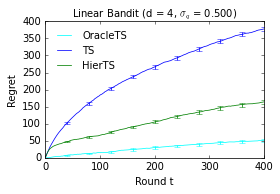

OracleTS: 28.6 +/- 3.0
TS: 348.0 +/- 6.1
HierTS: 241.2 +/- 9.4


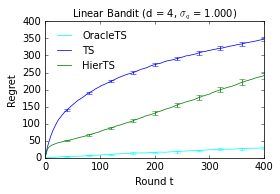

In [6]:
# linear bandit
alg_specs = [
    ("OracleTS", "cyan", "-"),
    ("TS", "blue", "-"),
    ("HierTS", "green", "-")]
num_runs = 100
num_tasks = 10
num_tasks_per_round = 5
n = 200 * num_tasks // num_tasks_per_round

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

for d in [4]:
  K = 5 * d
  for sigma_q_scale in [0.5, 1]:
    # meta-prior parameters
    mu_q = np.zeros(d)
    # prior parameters
    sigma_0 = 0.1
    # reward noise
    sigma = 1

    Sigma_q = np.square(sigma_q_scale) * np.eye(d)
    Sigma_0 = np.square(sigma_0) * np.eye(d)


    plt.figure(figsize=(4, 2.8))

    for alg_spec in alg_specs:
      regret = np.zeros((n, num_runs))

      for run in range(num_runs):
        # true hyper-prior
        mu_star = mu_q + sigma_q_scale * np.random.randn(d)
        envs = []
        for _ in range(num_tasks):
          # sample problem instance from N(\mu_*, \sigma_0^2 I_d)
          theta = mu_star + sigma_0 * np.random.randn(d)
          # sample arms from a unit ball
          X = np.random.randn(K, d)
          X /= np.linalg.norm(X, axis=-1)[:, np.newaxis]
          envs.append(LinBandit(X, theta, sigma=sigma))

        # initialize algorithms
        if alg_spec[0] == 'OracleTS':
          # OracleTS
          alg_params = {
            "theta0": np.copy(mu_star),
            "Sigma0": np.copy(Sigma_0),
            "sigma": sigma}
          alg = IndLinTS(num_tasks, K, d, alg_params)
        elif alg_spec[0] == 'TS':
          # TS
          alg_params = {
            "theta0": np.copy(mu_q),
            "Sigma0": Sigma_q + Sigma_0,
            "sigma": sigma}
          alg = IndLinTS(num_tasks, K, d, alg_params)
        else:
          # HierTS
          alg_params = {
              "mu_q": np.copy(mu_q),
              "Sigma_q": np.copy(Sigma_q),
              "Sigma0": np.copy(Sigma_0),
              "sigma": sigma,
          }
          alg = HierLinTS(num_tasks, K, d, alg_params)

        for t in range(n):
          tasks = np.random.randint(0, num_tasks, size=num_tasks_per_round)
  
          for s in tasks:
            envs[s].randomize()

          Xs = [envs[s].X for s in tasks]
          arms = alg.get_arm(t, tasks, Xs)
          rs = [envs[s].reward(arm) for s, arm in zip(tasks, arms)]
          alg.update(t, tasks, Xs, arms, rs)
          regret[t, run] = np.sum(
              [envs[s].regret(arm) for s, arm in zip(tasks, arms)])

      cum_regret = regret.cumsum(axis=0)
      plt.plot(step, cum_regret.mean(axis=1),
        dashes=linestyle2dashes(alg_spec[2]), color=alg_spec[1],
        label=alg_spec[0])
      plt.errorbar(step[sube], cum_regret[sube, :].mean(axis=1),
        cum_regret[sube, :].std(axis=1) / np.sqrt(cum_regret.shape[1]),
        fmt="none", ecolor=alg_spec[1])

      print("%s: %.1f +/- %.1f" % (alg_spec[0],
        cum_regret[-1, :].mean(),
        cum_regret[-1, :].std() / np.sqrt(cum_regret.shape[1])))

    plt.title(r"Linear Bandit (d = %d, $\sigma_q$ = %.3f)" % (d, sigma_q_scale))
    plt.xlabel("Round t")
    plt.xticks(np.arange(n + 1, step=100))
    plt.ylabel("Regret")
    plt.ylim(bottom=0)
    plt.legend(loc="upper left", frameon=False, prop={'size': 10})

    plt.tight_layout()
    plt.show()

In [ ]:
#@title
# linear bandit
alg_specs = [
  ("HierTS", "green", "-")]

num_runs = 100
num_tasks = 10

d = 2
K = 5 * d

sigma_q_scale = 0.5

# meta-prior parameters
mu_q = np.zeros(d)
sigma_q = sigma_q_scale * np.ones(d)
# prior parameters
sigma_0 = 0.1 * np.ones(d)
# reward noise
sigma = 1.0

Sigma_q = np.diag(np.square(sigma_q))
Sigma_0 = np.diag(np.square(sigma_0))

all_num_tasks_per_round = np.arange(1, num_tasks + 1)
total_regret = np.zeros((len(all_num_tasks_per_round), num_runs)) 

for i, num_tasks_per_round in enumerate(all_num_tasks_per_round):
  K = 5 * d
  n = num_tasks * 200 // num_tasks_per_round

  for alg_spec in alg_specs:
    regret = np.zeros((n, num_runs))

    for run in range(num_runs):
      # true hyper-prior
      mu_star = mu_q + sigma_q * np.random.randn(d)

      envs = []
      for task in range(num_tasks):
        # sample problem instance from N(\mu_*, \sigma_0^2 I_d)
        theta = mu_star + sigma_0 * np.random.randn(d)
        # sample arms from a unit ball
        X = np.random.randn(K, d)
        X /= np.linalg.norm(X, axis=-1)[:, np.newaxis]
        envs.append(LinBandit(X, theta, sigma=sigma))

      # initialize algorithms
      if alg_spec[0] == 'OracleTS':
        # OracleTS
        alg_params = {
          "theta0": np.copy(mu_star),
          "Sigma0": np.copy(Sigma_0),
          "sigma": sigma}
        alg = IndLinTS(num_tasks, K, d, alg_params)
      elif alg_spec[0] == "TS":
        # TS
        alg_params = {
          "theta0": np.copy(mu_q),
          "Sigma0": Sigma_q + Sigma_0,
          "sigma": sigma}
        alg = IndLinTS(num_tasks, K, d, alg_params)
      else:
        # HierTS
        alg_params = {
            "mu_q": np.copy(mu_q),
            "Sigma_q": np.copy(Sigma_q),
            "Sigma0": np.copy(Sigma_0),
            "sigma": sigma
        }
        alg = HierLinTS(num_tasks, K, d, alg_params)

      for t in range(n):
        tasks = np.random.choice(
            np.arange(num_tasks), size=num_tasks_per_round, replace=False)

        for s in tasks:
          envs[s].randomize()

        Xs = [envs[s].X for s in tasks]
        arms = alg.get_arm(t, tasks, Xs)
        rs = [envs[s].reward(arm) for s, arm in zip(tasks, arms)]
        alg.update(t, tasks, Xs, arms, rs)

        regret[t, run] = np.sum(
            [envs[s].regret(arm) for s, arm in zip(tasks, arms)])

    total_regret[i] = regret.cumsum(axis=0)[-1, :]
    print("L = %d: %.1f +/- %.1f" % (num_tasks_per_round,
      total_regret[i].mean(),
      total_regret[i].std() / np.sqrt(total_regret.shape[1])))

plt.figure(figsize=(4, 2.8))
plt.plot(all_num_tasks_per_round, total_regret.mean(axis=1),
  dashes=linestyle2dashes(alg_spec[2]), color=alg_spec[1],
  label=alg_spec[0])
plt.errorbar(all_num_tasks_per_round, total_regret.mean(axis=1),
  total_regret.std(axis=1) / np.sqrt(total_regret.shape[1]),
  fmt="none", ecolor=alg_spec[1])
    
plt.title(r"Linear (d = %d, $\sigma_q$ = %.3f)" % (d, sigma_q_scale))
plt.xlabel("Number of Concurrent Tasks L")
plt.ylabel("Regret")
plt.legend(loc="upper left", frameon=False)
plt.yticks(np.arange(50, 101, step=10))

plt.tight_layout()
plt.show()

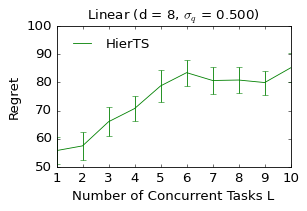

In [ ]:
#@title
alg_spec = ("HierTS", "green", "-")

plt.figure(figsize=(4, 2.8))
plt.plot(all_num_tasks_per_round, total_regret.mean(axis=1),
  dashes=linestyle2dashes(alg_spec[2]), color=alg_spec[1],
  label=alg_spec[0])
plt.errorbar(all_num_tasks_per_round, total_regret.mean(axis=1),
  total_regret.std(axis=1) / np.sqrt(total_regret.shape[1]),
  fmt="none", ecolor=alg_spec[1])
    
plt.title(r"Linear (d = %d, $\sigma_q$ = %.3f)" % (d, sigma_q_scale))
plt.xlabel("Number of Concurrent Tasks L")
plt.ylabel("Regret")
plt.legend(loc="upper left", frameon=False)
plt.yticks(np.arange(50, 101, step=10))

plt.tight_layout()
plt.show()